In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
from random import choices
from scipy.spatial import ConvexHull, convex_hull_plot_2d
S = 2000

T = 1000 # for the long term make T larger. 
alpha = 0.5
eps = 0.3
gamma = 0.8
neg_reward = -1
tau = 10

# functions
def normalize(neg_reward):
    rew = np.concatenate((np.zeros(int (T/2)), neg_reward*np.ones(int (T/2))))
    norm = np.std(rew, ddof=1)
    return norm

#--------threat, reward normalized here--------------
std_thr = normalize(neg_reward)
std_rew = 205.68833780186057
#--------------------------------------------
print(std_thr)
def linear_scalar (Q, w, epsilon):
    temp = Q[0,:]*w[0] + Q[1,:]*w[1]
    if np.random.uniform(0,1) < epsilon:
        action = np.random.randint(0,4)
    else:
        action = np.random.choice(np.array(np.where(temp == np.amax(temp))).flatten())
    return action

def softmax_one (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    #print(weights)
    population = np.arange(np.size(Q,1))
    
    action = choices(population, weights)
    return action[0]

def softmax_two (Q, w, tau):
    ex_zero =  np.exp((Q[0,:] - np.max(Q[0,:]))/tau)
    weights_zero = ex_zero/np.sum(ex_zero)
    ex_one =  np.exp((Q[1,:] - np.max(Q[1,:]))/tau)
    weights_one = ex_one/np.sum(ex_zero)
    
    weights = w[0]*weights_zero + w[1]*weights_one
    #print('-----------')
    #print(w)
    #print(weights_zero, weights_one)
    #print(weights)
    population = np.arange(np.size(Q,1))

    action = choices(population, weights)
    
    return action[0]
# this first
# choose reference point low enough for Q value
# or if in terms of regrets, choose in third quadrant

def Hypervolume (Q, refpoint, tau):
    # Q is 2x4
    # l is 2xt
    temp = np.zeros(4)
    for i in range(4):
        temp[i] = (Q[0,i] - refpoint[0])*(Q[1,i] - refpoint[1])
    temp = np.absolute(temp)
    # print(temp)
    
    
    # softmax applied to 4 hypervolume arrays now
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    #print(weights)
    population = np.arange(np.size(Q,1))
    
    action = choices(population, weights)
    return action[0]

def update(curr_action, Q, next_action, r, obj):
    predict = Q[obj, curr_action]
    target = r+ gamma*Q[obj, next_action]
    Q[obj, curr_action] = Q[obj, curr_action]*(1-alpha) + alpha*target

def step(curr_action):
    # actions {0,1,2,3} correspond to decks {A,B,C,D}
    if curr_action == 0:
        reward = np.random.choice([100,-150])
        threat = 0
    elif curr_action == 1:
        if np.random.uniform(0,1) < 0.1:
            reward = -1150
        else:
            reward = 100
        threat = 0
    elif curr_action == 2:
        reward = np.random.choice([0,50])
        threat = neg_reward
    else:
        if np.random.uniform(0,1) < 0.1:
            reward = -200
        else:
            reward = 50
        threat = neg_reward
    reward/=std_rew
    threat/=std_thr
    return reward, threat

#----------------TRAINING STARTS HERE --------------------
# partition parameter
p = 0.05
W = int(1/p) + 1

Q = np.zeros((S,2,4,W))

reward_regret = np.zeros((S,T,W))
threat_regret = np.zeros((S,T,W))
actions = np.zeros((S,4,W))

max_reward_mean = 25/std_rew
max_threat_mean = 0

for w in range(W):
    for s in range(S):
        refpoint = np.array([w*p,1-w*p])
        for t in range(T):
            curr_action = Hypervolume(Q[s,:,:,w], refpoint, tau)
            #print("action = ", curr_action)
            actions[s,curr_action,w]+=1
            reward, threat = step(curr_action)
       
            #print("reward = ", np.round(reward,3))
            #print("threat = ", np.round(threat,3))
            next_action = Hypervolume(Q[s,:,:,w], refpoint, 0.001)
            
            update(curr_action, Q[s,:,:,w], next_action, reward, 0)
            update(curr_action, Q[s,:,:,w], next_action, threat, 1)
            #print(np.round(Q[s,:,:,w],3))
            reward_regret[s,t,w] = max_reward_mean - reward
           
            threat_regret[s,t,w] = max_threat_mean - threat
            


0.5002501876563868


In [2]:
from random import choices
a = [0,1,2,3]
b = [0.25,0.25,0.25,0.25]
#print(choices(a,b))
#print(np.cumsum(reward_regret[0,:,W-45]))
#print(np.cumsum(threat_regret[0,:,W-45]))
for w in range(W):
    print(np.mean(Q[:,:,:,w],0))

[[ 0.01288838 -0.0249981   0.31309686  0.21915876]
 [-3.9785913  -3.50019751 -7.16577209 -7.36523328]]
[[ 0.02337578 -0.07592996  0.30054104  0.24470338]
 [-3.82816126 -3.32911005 -6.73851289 -7.03020754]]
[[ 0.05466088 -0.06180522  0.30058413  0.2623506 ]
 [-3.64229465 -3.22152689 -6.42110047 -6.71326897]]
[[ 0.08386919 -0.03318894  0.30997993  0.29894887]
 [-3.51663984 -3.17329252 -6.20405934 -6.55312625]]
[[ 0.1053337  -0.01639332  0.33519137  0.32620299]
 [-3.48700972 -3.12360534 -6.04523819 -6.36543195]]
[[ 0.14049954 -0.04567928  0.35835473  0.34494342]
 [-3.42271334 -3.08548625 -6.00678088 -6.30433015]]
[[ 1.31250268e-01 -2.87281577e-03  3.57669867e-01  3.49269314e-01]
 [-3.37066624e+00 -3.03367515e+00 -5.84540630e+00 -6.11530044e+00]]
[[ 0.16387761  0.01085514  0.38265228  0.37899651]
 [-3.34481041 -3.0429946  -5.80161005 -6.04104802]]
[[ 1.89468579e-01 -2.60238475e-03  4.01948779e-01  4.00618132e-01]
 [-3.34368541e+00 -3.01501937e+00 -5.79748158e+00 -6.00692266e+00]]
[[ 0.2014

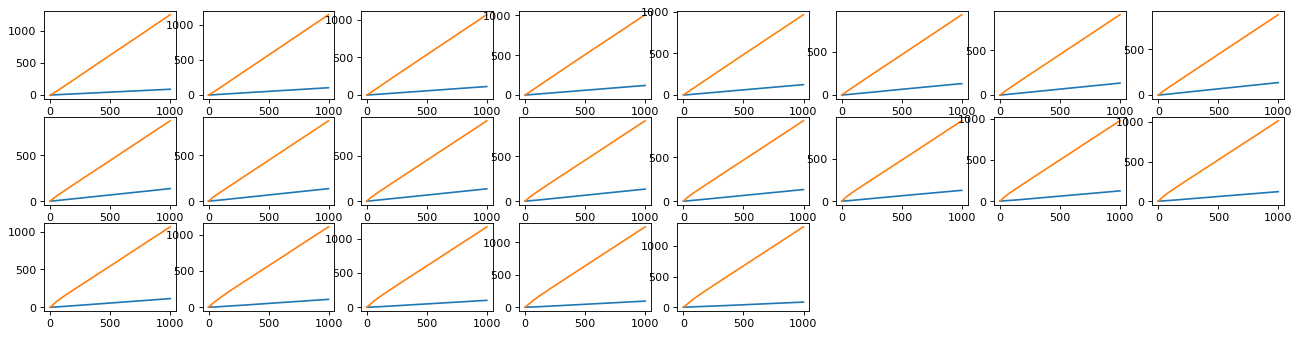

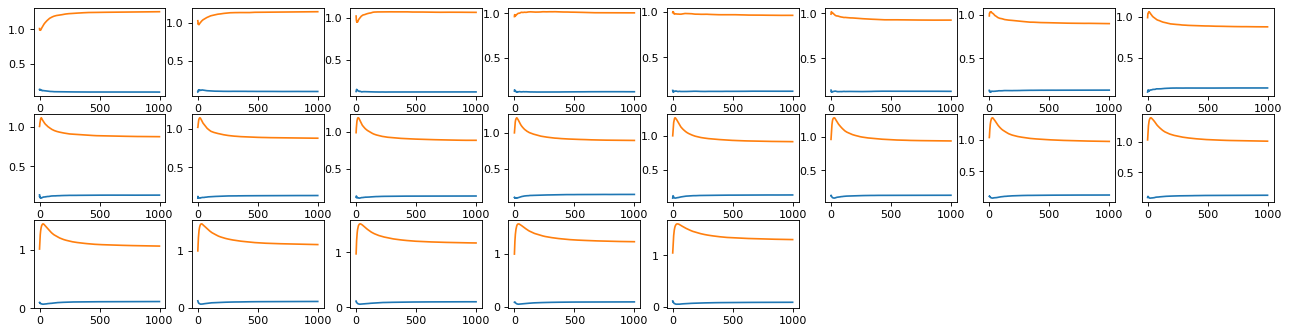

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20,12), dpi=80)

x = np.arange(T)
plt.figure(1)
cum_rew_regret = np.zeros((T,W))
cum_thr_regret = np.zeros((T,W))
for w in range(W):
    cum_rew_regret[:,w] = np.cumsum(np.mean(reward_regret[:,:,w], 0))
    cum_thr_regret[:,w] = np.cumsum(np.mean(threat_regret[:,:,w], 0))
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w])
    #plt.legend(['reward regret', 'threat regret'])
    #print(cum_rew_regret)
# now plot time-averaged regrets

for t in range(T):
    cum_rew_regret[t,:]/=(t+1)
    cum_thr_regret[t,:]/=(t+1)

figure(figsize=(20,12), dpi=80)
plt.figure(2)
for w in range(W):
    plt.subplot(7,8,w+1)
    plt.plot(x, cum_rew_regret[:,w], x, cum_thr_regret[:,w] )

In [4]:
# some debugging
# debugging a bit here\n",
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
for w in range(W):
    print(np.mean(actions[:,:,w], 0))
    print(np.round(np.mean(Q[:,0,:,w]*w+Q[:,1,:,w]*(W-w), axis=(0,1)),2))


[102.8725 269.4995 357.3755 270.2525]
-115.55
[121.513 306.27  299.661 272.556]
-104.51
[137.5645 329.0205 264.135  269.28  ]
-94.71
[151.4315 345.0435 236.0625 267.4625]
-87.02
[163.9395 354.4575 220.242  261.361 ]
-80.09
[176.569 361.005 208.169 254.257]
-74.28
[189.595  360.6305 203.1455 246.629 ]
-67.62
[200.9195 358.642  200.0495 240.389 ]
-62.17
[209.9195 352.3045 200.222  237.554 ]
-57.05
[220.0275 341.5385 202.987  235.447 ]
-52.33
[229.0145 328.866  207.446  234.6735]
-47.61
[237.3565 314.224  212.774  235.6455]
-43.15
[246.92  294.785 221.177 237.118]
-38.17
[252.202  275.9915 231.607  240.1995]
-33.49
[259.0485 253.458  243.959  243.5345]
-28.67
[260.017  231.9455 258.0075 250.03  ]
-24.07
[262.4855 206.145  275.387  255.9825]
-18.86
[259.6675 183.726  293.1885 263.418 ]
-13.75
[257.5245 155.552  316.878  270.0455]
-7.95
[249.8295 131.5035 338.5945 280.0725]
-1.91
[237.139  107.686  364.5005 290.6745]
4.66


<Figure size 1280x800 with 0 Axes>

In [5]:
import numpy as np 
from random import choices
population = [1, 2, 3, 4, 5, 6]
weights = [0.1, 0.05, 0.05, 0.2, 0.4, 0.2]

def softmax (Q, w, tau):
    temp = (Q[0,:]*w[0] + Q[1,:]*w[1])/tau 
    ex = np.exp(temp - np.max(temp))
    weights = ex/np.sum(ex)
    print(weights)
    population = np.arange(np.size(Q,1))
    return choices(population, weights)
QQ = np.array([ [1, 3, 4, 4],
      [-1,2,3,10]])

print(np.array(np.where(QQ == np.amax(QQ))))
print(softmax(QQ, [0.5,0.5], 0.3))

[[1]
 [3]]
[7.35289276e-11 3.05899604e-07 8.57486295e-06 9.99991119e-01]
[3]


[1.25462822 1.14386164 1.06629645 1.00654635 0.96272428 0.92438946
 0.89909911 0.88043645 0.87511411 0.87642946 0.88379677 0.89639047
 0.91613159 0.94314108 0.97449938 1.01556684 1.0622075  1.11265625
 1.17325993 1.23671518 1.30969466]
[0.09111625 0.104376   0.1133776  0.12050489 0.12505218 0.13170168
 0.13425445 0.13656802 0.13663548 0.1364652  0.13537812 0.13427463
 0.13201514 0.12695032 0.12453672 0.1198144  0.11390595 0.10884295
 0.10021181 0.09364824 0.08358398]
1.2546282150145054 0.09111624995508218
1.1438616398741763 0.10437599539882828
1.066296451579522 0.11337759957234021
1.0065463490557585 0.12050488746657267
0.9627242765390004 0.12505217979240682
0.9243894583356502 0.13170168172633576
0.8990991130001065 0.13425445163838498
0.8751141145012333 0.13663548113783963
0.8764294563366504 0.13646519924254946
0.8837967699148152 0.13537811767832683
0.8963904683390262 0.1342746277944294
0.9161315903689158 0.13201514140367615
0.943141075489352 0.12695031852099237
0.9744993845656383 0.124

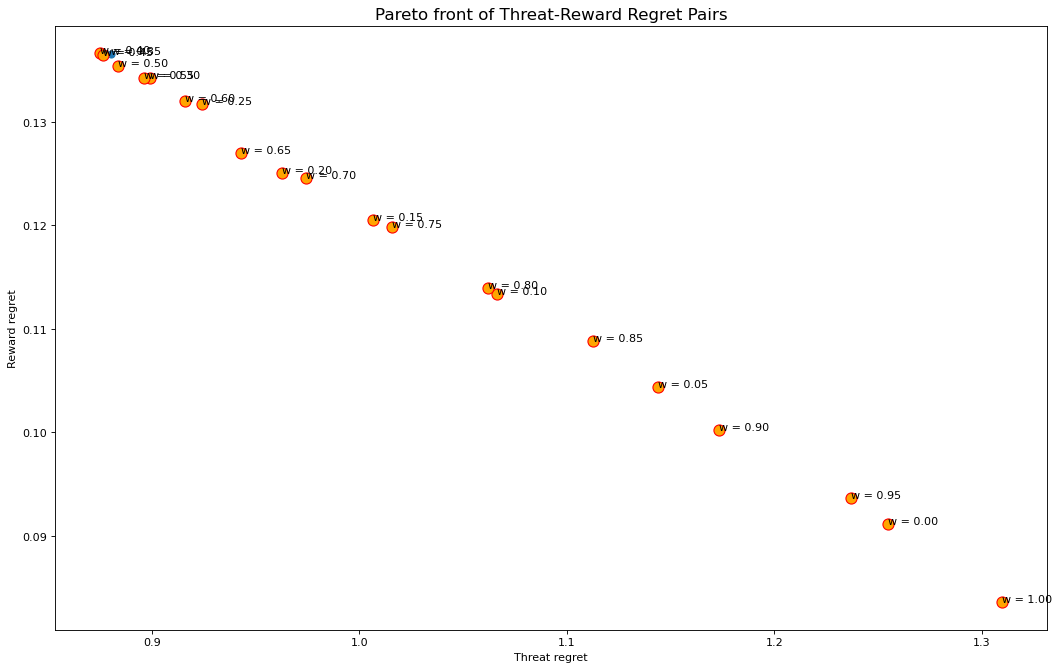

In [6]:
# plotting asymptotics against the weight.
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16, 10), dpi=80)
np.shape(reward_regret)
y = cum_rew_regret[T-1,:] # make T larger average over last few time steps
x = cum_thr_regret[T-1,:]
print(x)
print(y)
annotations=[]

for w in range(W):
    f = format(w*p, ".2f")
    annotations = np.append(annotations,"w = "+str(f) )
plt.scatter(x,y, s=40)
plt.xlabel("Threat regret")
plt.ylabel("Reward regret")
plt.title("Pareto front of Threat-Reward Regret Pairs",fontsize=15)
for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y[i]))

#plt.text(0.8,0.235, 'w is the weight on reward', style='italic',
        #bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)
#plt.text(0.8,0.22, 'so 1-w is the weight on threat', style='italic',
        #bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10},fontsize=20)


# Pareto front plotter
# returns true only if (a,b) is not Pareto dominated by (a1,b1)
def isPareto(a,b,a1,b1):
    if a1 > a:
        return True
    elif b1 > b:
        return True
    else:
        return False
#print(isPareto(0.2,0.2,0.2,0.2))

n = np.size(x)
for i in range(n):
    count = 0
    for j in range(n):
        if  isPareto(x[i], y[i], x[j], y[j]):
            count+=1
    #print(x[i], y[i])
    #print(count)
    if count==n-1:
        print(x[i],y[i])
        plt.plot(x[i], y[i],marker="o",markersize=10, markeredgecolor="red",
            markerfacecolor="orange")
        #plt.annotate(x[i], y[i])
plt.show()

True


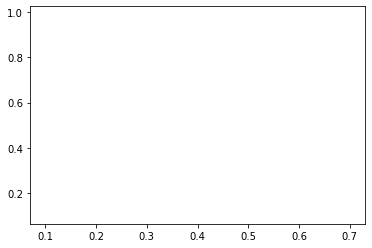

In [7]:
# Pareto front plotter
# Decides if (a,b) Pareto Dominates (a1,b1)
def isPareto(a,b,a1,b1):
    if a>a1:
        return False
    elif b>b1:
        return False
    else:
        return True
print(isPareto(0.1,0.1,0.2,0.2))
x = [0.1,0.2,0.4,0.7]
y = [0.23,0.11,0.98,0.87]
n = np.size(x)
for i in range(n):
    temp = True
    for j in range(n):
        temp = isPareto(x[i],y[i],x[j],y[j])
        plt.plot(x[i], y[i],markersize=20, markeredgecolor="red",
markerfacecolor="green")